In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import gpflow

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import pickle
from pathlib import Path

In [5]:
from helpers import *

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [7]:
plt.rcParams.update({'font.size': 16})

In [8]:
from bokeh.palettes import d3
from bokeh.layouts import column

In [9]:
pallete = d3['Category10'][10]

In [10]:
from tqdm.autonotebook import tqdm

<ipython-input-10-d05506e76d3e>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load controller data:

In [11]:
sim_id = "1_SVGP_480pts_inf_window_12_averageYear"
sim_path = Path("../Data/Simulation_results/Third batch/", sim_id)
scaler = pickle.load(open(Path(sim_path, "controller_scaler.pkl"), 'rb'))
scaler_helper = ScalerHelper(scaler)
model = pickle.load(open(Path(sim_path, "controller_model.pkl"), 'rb'))
df = pd.read_pickle(Path(sim_path, "controller_df.pkl"))
X_log = pickle.load(open(Path(sim_path,"controller_X_log.pkl"), 'rb'))
if "_SVGP_" in sim_id:
    model_log = pickle.load(open(Path(sim_path,"controller_model_log.pkl"), 'rb'))

In [12]:
Tsample = 900

In [13]:
nb_id_pts = 5 * (24 * 3600) // Tsample

### Compute the time index

In [14]:
df.index = pd.to_datetime('01-01-2010') + pd.to_timedelta(df.index * Tsample, unit = 'second')

In [15]:
df.head()

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
2010-01-01 00:00:00,0.0,6.5,55547.786720,23.000000
2010-01-01 00:15:00,0.0,6.5,-39165.779392,24.739668
2010-01-01 00:30:00,0.0,6.5,228.533082,16.168273
2010-01-01 00:45:00,0.0,6.5,63000.000000,17.902811
2010-01-01 01:00:00,0.0,6.5,30880.314927,22.920173


### Get reference temperature

In [16]:
df_tref = df['OutsideTemp'].rolling(
    window = 2 * 96
).mean().apply(get_tref_mean)

df_tref = df_tref.shift(1) # The reference at time t is computed using info up to t-1

In [17]:
err_mean = (df['SimulatedTemp'] - df_tref).mean()
err_std = (df['SimulatedTemp'][500:] - df_tref).std()
print(f"Error mean: {np.round(err_mean, 2)}, std: {np.round(err_std,2)}")

Error mean: -0.06, std: 0.25


In [18]:
df_rolling_temp = (df['SimulatedTemp']).rolling(window = 1 * 96).mean()
df_rolling_err = (df['SimulatedTemp'] - df_tref).rolling(window = 7 * 96).mean()

Recreate `dict_cols`:

In [19]:
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

t_lags = 0
w_lags = 1
u_lags = 2
y_lags = 3

dict_cols = {
  't': (t_lags, t_cols),
  'w': (w_lags, w_cols),
  'u': (u_lags, u_cols),
 'y': (y_lags, y_cols)
}

In [20]:
# Scale the dataframe
df_sc = get_scaled_df(df, dict_cols, scaler)
# Get the GP input from the scaled df
df_gpr = data_to_gpr(df_sc, dict_cols)
df_gpr.head()

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
2010-01-01 00:45:00,-1.0,-1.0,-0.307018,-0.307018,1.000000,1.000000,0.857708,0.888018,0.657471,0.113282,0.532905
2010-01-01 01:00:00,-1.0,-1.0,-0.307018,-0.307018,-0.058287,1.000000,1.000000,1.000000,0.888018,0.657471,0.113282
2010-01-01 01:15:00,-1.0,-1.0,-0.321272,-0.307018,-0.492455,-0.058287,1.000000,-0.096136,1.000000,0.888018,0.657471
2010-01-01 01:30:00,-1.0,-1.0,-0.335526,-0.321272,1.000000,-0.492455,-0.058287,-0.799554,-0.096136,1.000000,0.888018
2010-01-01 01:45:00,-1.0,-1.0,-0.349781,-0.335526,1.000000,1.000000,-0.492455,0.567386,-0.799554,-0.096136,1.000000


In [21]:
def RMSE(measured, predicted):
    N = measured.size
    RMSE = np.sqrt(np.power(measured - predicted, 2).sum()/N)
    return RMSE

## Multistep prediction

In [22]:
df_input = df_gpr.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = df_gpr[dict_cols['y'][1]]

In [23]:
model_idx = 0

In [24]:
if "_SVGP_" in sim_id:
    m = model_log[model_idx]
else:
    m = model

In [25]:
y_name = dict_cols['y'][1][0]

In [26]:
nb_predictions = 25
N_pred = 20

In [27]:
def get_multistep_plot():
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 5))

    iter_start_idx = iter([250, 500, 10750, 11000])

    # x-axis handles
    locators = []
    formatters = []

    for plt_idx in range(4):
        start_idx = next(iter_start_idx)
        # Subfigure
        plt.subplot(2, 2, plt_idx + 1)
        for idx in range(start_idx, start_idx + nb_predictions):
            df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
            for idxx in range(N_pred - 1):
                idx_old = df_iter.index[idxx]
                idx_new = df_iter.index[idxx+1]
                mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
                df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
                for lag in range(2, dict_cols['y'][0] + 1):
                    df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]

            mean_iter, _ = m.predict_f(df_iter.to_numpy())
            mean_iter = scaler_helper.inverse_scale_output(mean_iter) 
            l1 = plt.plot(df_iter.index, mean_iter, '.-', color = pallete[1], label = '20-step ahead prediction')
        l2 = plt.plot(df.iloc[3 + start_idx:2 + start_idx + nb_predictions + N_pred, 3], 'o-', color = pallete[0], label = 'Carnot Temperature')
        plt.title(f"Prediction starting at experimental step {start_idx}")

    for ax_idx in range(2):
        for ax_idy in range(2):

            if ax_idx == 1:
                ax[ax_idx][ax_idy].set_xlabel("Experiment time [date]")

            ax[ax_idx][ax_idy].set_ylabel("Temperature [°C]")

            locators.append(mdates.AutoDateLocator(minticks=3, maxticks=6))
            formatters.append(mdates.ConciseDateFormatter(locators[-1]))
            ax[ax_idx][ax_idy].xaxis.set_major_locator(locators[-1])
            ax[ax_idx][ax_idy].xaxis.set_major_formatter(formatters[-1])


    handles, labels = ax[0][0].get_legend_handles_labels()
    idx = np.sort(np.unique(np.array(labels), return_index=True)[1])
    fig.legend(np.array(handles)[idx], np.array(labels)[idx])
    fig.suptitle(f"20-step ahead prediction simulation for identified model no. {model_idx}")

    # Adjusting the sub-plots
    fig.subplots_adjust(right=0.975)
    fig.subplots_adjust(hspace=0.35)

    return fig
#plt.savefig(f"../Thesis/Plots/{sim_id}_last_model_performance.pdf", bbox_inches='tight')

In [ ]:
if "_SVGP_" in sim_id:
    
    for model_idx in tqdm(range(len(model_log))):
        m = model_log[model_idx]
        fig = get_multistep_plot()
        plt.savefig(f"../Presentation/Plots/{sim_id}_model_{model_idx}_performance.pdf", bbox_inches='tight')
        print(f"saved {model_idx} perf")
else:
    m = model
    fig = get_multistep_plot()
    plt.savefig(f"../Thesis/Plots/{sim_id}_model_performance.pdf", bbox_inches='tight')
    print(f"saved GP perf")

> <ipython-input-26-fab78f105819>(21)get_multistep_plot()
     19                 idx_new = df_iter.index[idxx+1]
     20                 import pdb; pdb.set_trace()
---> 21                 mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
     22                 df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
     23                 for lag in range(2, dict_cols['y'][0] + 1):



ipdb>  df_iter.loc[idx_old, :].to_numpy().reshape(1, -1)


array([[-0.34532374,  0.31261426,  1.        , -0.41376461,  0.8349958 ,
         0.78423814]])


ipdb>  m


ipdb>  m.predict_f([1,1,1,1,1,1,1])


*** tensorflow.python.framework.errors_impl.InternalError: Blas xGEMM launch failed : a.shape=[1,477,6], b.shape=[1,477,6], m=477, n=477, k=6 [Op:MatMul]


ipdb>  m.predict_y([1,1,1,1,1,1,1])


## Plot year-long evolution

In [20]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [21]:
output_notebook()

Loading BokehJS ...

In [22]:
p = figure(plot_width = 1000, plot_height = 300)
#p.line(df.index, df['OutsideTemp'], line_color = pallete[0])
p.line(df.index, df['SimulatedTemp'], line_color = pallete[1])
p.line(df.index, df_tref, line_color = pallete[2])
p.line(df.index, df_rolling_temp, line_color = pallete[3])


show(p)

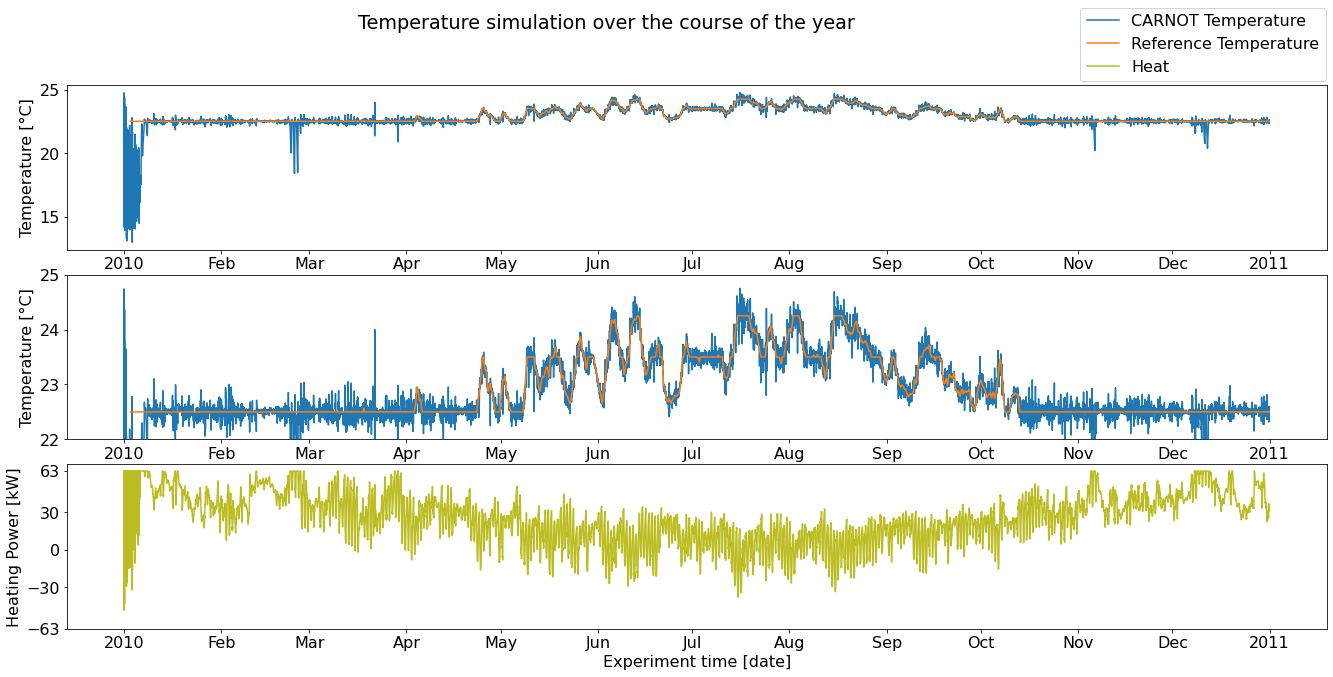

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
#plt.plot(df.index, df['OutsideTemp'], color = 'blue')
ax[0].plot(df.index, df['SimulatedTemp'], color = pallete[0], label = 'CARNOT Temperature')
ax[0].plot(df.index, df_tref, color = pallete[1], label = 'Reference Temperature')

ax[1].plot(df.index, df['SimulatedTemp'], color = pallete[0])
ax[1].plot(df.index, df_tref, color = pallete[1])
ax[1].set_ylim([22,25])

ax[2].plot(df.index, df['SimulatedHeat']/1000, color = pallete[8], label = 'Heat')
heat_ticks = [-63, -30, 0, 30, 63]
ax[2].set_yticks(heat_ticks)

fig.suptitle("Temperature simulation over the course of the year")

ax[0].set_ylabel("Temperature [°C]")
ax[1].set_ylabel("Temperature [°C]")
ax[2].set_ylabel("Heating Power [kW]")

ax[2].set_xlabel("Experiment time [date]")

handles, labels = [], []

for idx in range(3):
    handles.extend(ax[idx].get_legend_handles_labels()[0])
    labels.extend(ax[idx].get_legend_handles_labels()[1])

#handles, labels = ax[0].get_legend_handles_labels()
idx = np.sort(np.unique(np.array(labels), return_index=True)[1])
fig.legend(np.array(handles)[idx], np.array(labels)[idx])

locator = mdates.AutoDateLocator(minticks=3, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
for idx in range(3):
    ax[idx].xaxis.set_major_locator(locator)
    ax[idx].xaxis.set_major_formatter(formatter)



# Adjusting the sub-plots
plt.subplots_adjust(right=1)
fig.subplots_adjust(hspace=0.15)

plt.savefig(f"../Thesis/Plots/{sim_id}_fullyear.pdf", bbox_inches='tight')

In [24]:
cum_se = ((df['SimulatedTemp'][500:] - df_tref[500:])**2).sum()
print(cum_se)

2242.879438249995


In [25]:
p = figure(plot_width = 1000, plot_height = 300)
p.scatter(df.index, np.abs(df['SimulatedTemp'] - df_tref))
show(p)

In [26]:
np_abserr = (df['SimulatedTemp'] - df_tref).abs()
abserr_mean = np_abserr.median()
abserr_std = np_abserr.std()

In [27]:
abserr_mean

0.0547474281380147

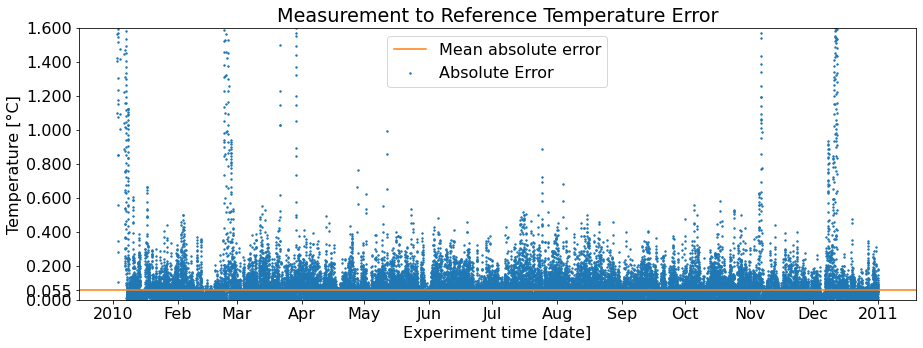

In [28]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.scatter(df.index, np_abserr, s = 2, label = 'Absolute Error')

ax.set_ylim([0,1.5])
plt.yticks(list(plt.yticks()[0]) + [abserr_mean])
ax.axhline(y = abserr_mean, color = pallete[1], ls = '-', label = 'Mean absolute error')

locator = mdates.AutoDateLocator(minticks=3, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Temperature [°C]")

ax.set_xlabel("Experiment time [date]")

plt.legend()

plt.title("Measurement to Reference Temperature Error")
plt.savefig(f"../Thesis/Plots/{sim_id}_abserr.pdf", bbox_inches='tight')

In [29]:
np_params = np.empty((0, 8))
np_params

array([], shape=(0, 8), dtype=float64)

In [30]:
for model in model_log:
    variance = gpflow.utilities.parameter_dict(model)['.kernel.variance'].numpy()
    lscales = gpflow.utilities.parameter_dict(model)['.kernel.lengthscales'].numpy()
    iter_params = np.hstack([variance, lscales])
    np_params = np.vstack([np_params, iter_params])

In [49]:
np_params_idx = np.array([*range(np_params.shape[0])])

In [50]:
p_list = []
for idx in range(1, np_params.shape[1]):
    p = figure(plot_width = 1000, plot_height = 150)
    p.line(np_params_idx, np_params[:, idx], line_color = pallete[idx])
    p_list.append(p)
show(column(p_list))

In [31]:
import matplotlib.gridspec as gridspec

In [32]:
np_params_idx = np.array([*range(np_params.shape[0])])

In [33]:
# date in american format because of course it is
np_params_idx = pd.to_datetime('01-06-2010') + pd.to_timedelta(np_params_idx, unit = 'days')

In [34]:
lscales_locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
lscales_formatter = mdates.ConciseDateFormatter(locator)

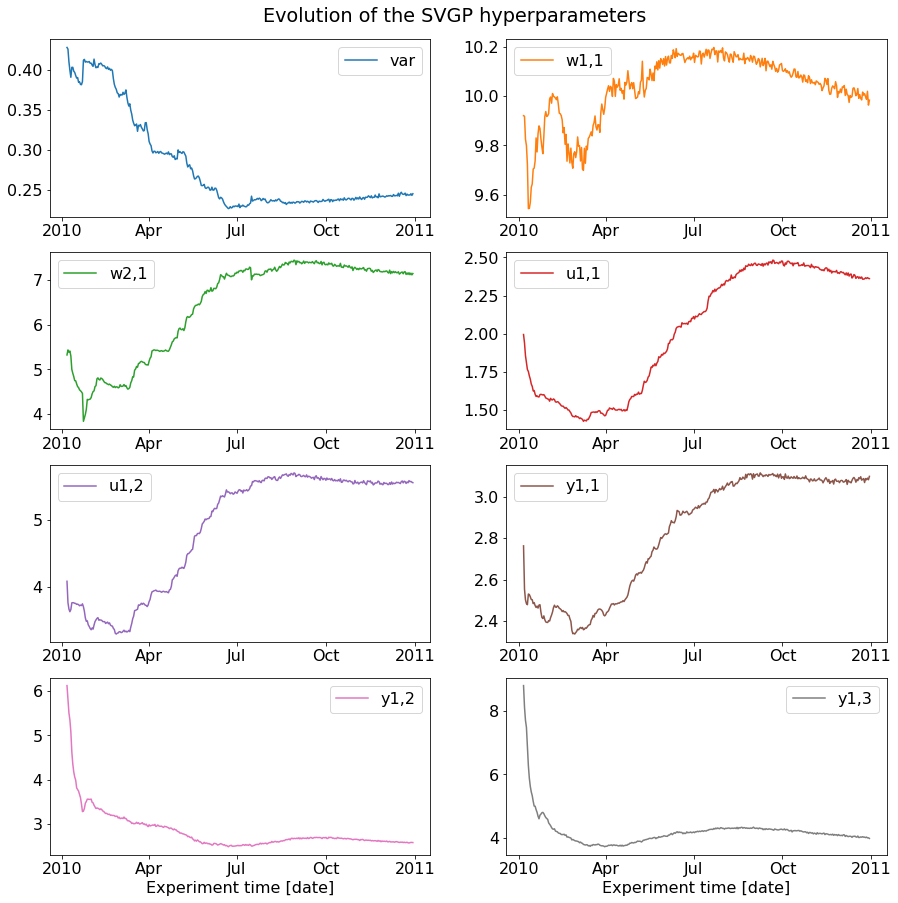

In [35]:
gs = gridspec.GridSpec(4, 2)

fig = plt.figure(figsize = (15, 15))

ax_lscales = []
lscale_names = ['var', 'w1,1', 'w2,1', 'u1,1', 'u1,2', 'y1,1', 'y1,2', 'y1,3']
for idx in range(4):
    for idxx in range(2):
        ax_iter = fig.add_subplot(gs[idx, idxx])
        lscale_idx = 2 * idx + idxx
        ax_iter.plot(np_params_idx, np_params[:, lscale_idx], color = pallete[lscale_idx], label = lscale_names[lscale_idx])
        ax_iter.legend()
        
        ax_iter.xaxis.set_major_locator(lscales_locator)
        ax_iter.xaxis.set_major_formatter(lscales_formatter)
        
        ax_lscales.append(ax_iter)
        
ax_lscales[-1].set_xlabel("Experiment time [date]")
ax_lscales[-2].set_xlabel("Experiment time [date]")

        
fig.suptitle("Evolution of the SVGP hyperparameters", y = 0.91)
plt.savefig(f"../Thesis/Plots/{sim_id}_evol_hyperparameters.pdf", bbox_inches='tight')

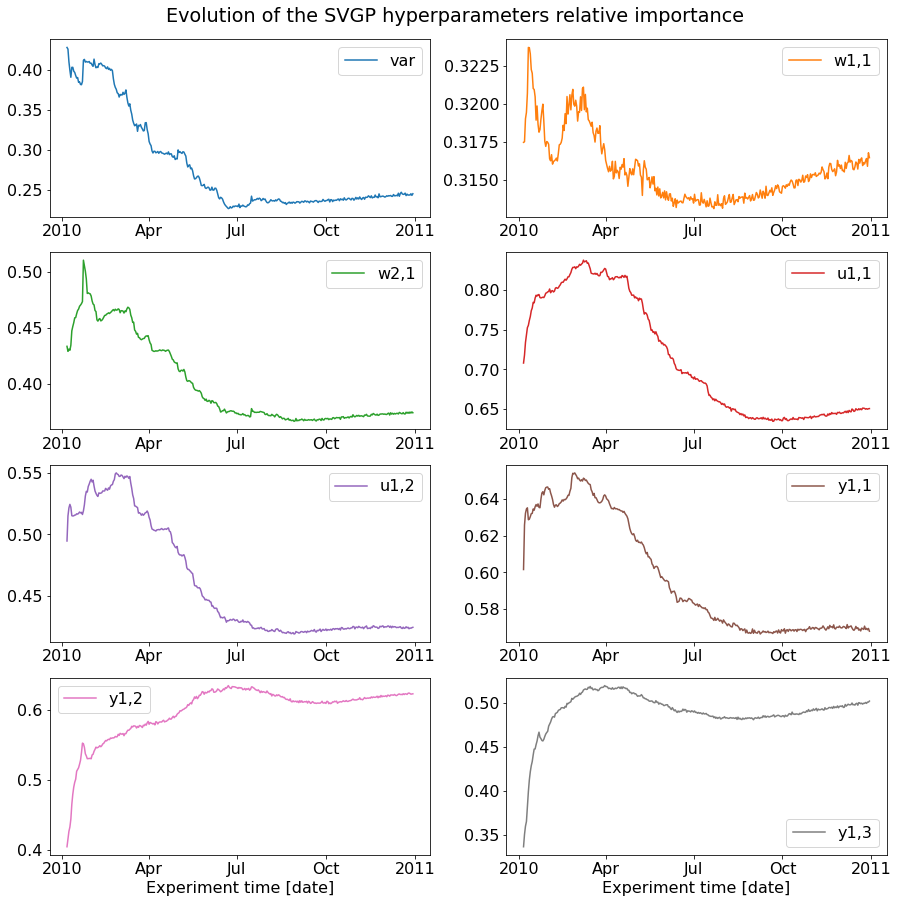

In [36]:
fig = plt.figure(figsize = (15, 15))

ax_lscales = []
lscale_names = ['var', 'w1,1', 'w2,1', 'u1,1', 'u1,2', 'y1,1', 'y1,2', 'y1,3']
for idx in range(4):
    for idxx in range(2):
        ax_iter = fig.add_subplot(gs[idx, idxx])
        lscale_idx = 2 * idx + idxx
        if lscale_idx == 0:
            ax_iter.plot(np_params_idx, np_params[:, lscale_idx], color = pallete[lscale_idx], label = lscale_names[lscale_idx])
        else:
            ax_iter.plot(np_params_idx, 1/np.sqrt(np_params[:, lscale_idx]), color = pallete[lscale_idx], label = lscale_names[lscale_idx])

        ax_iter.legend()
        
        ax_iter.xaxis.set_major_locator(lscales_locator)
        ax_iter.xaxis.set_major_formatter(lscales_formatter)
        
        ax_lscales.append(ax_iter)
        
ax_lscales[-1].set_xlabel("Experiment time [date]")
ax_lscales[-2].set_xlabel("Experiment time [date]")
        
fig.suptitle("Evolution of the SVGP hyperparameters relative importance", y = 0.91)
plt.savefig(f"../Thesis/Plots/{sim_id}_evol_importance.pdf", bbox_inches='tight')

In [37]:
np_params.shape

(359, 8)

In [38]:
var = np_params[0, 0]
lscales = np_params[0, 1:]

In [39]:
lscales

array([9.92074817, 5.32224587, 1.99507585, 4.08729764, 2.76345362,
       6.12604076, 8.8078413 ])

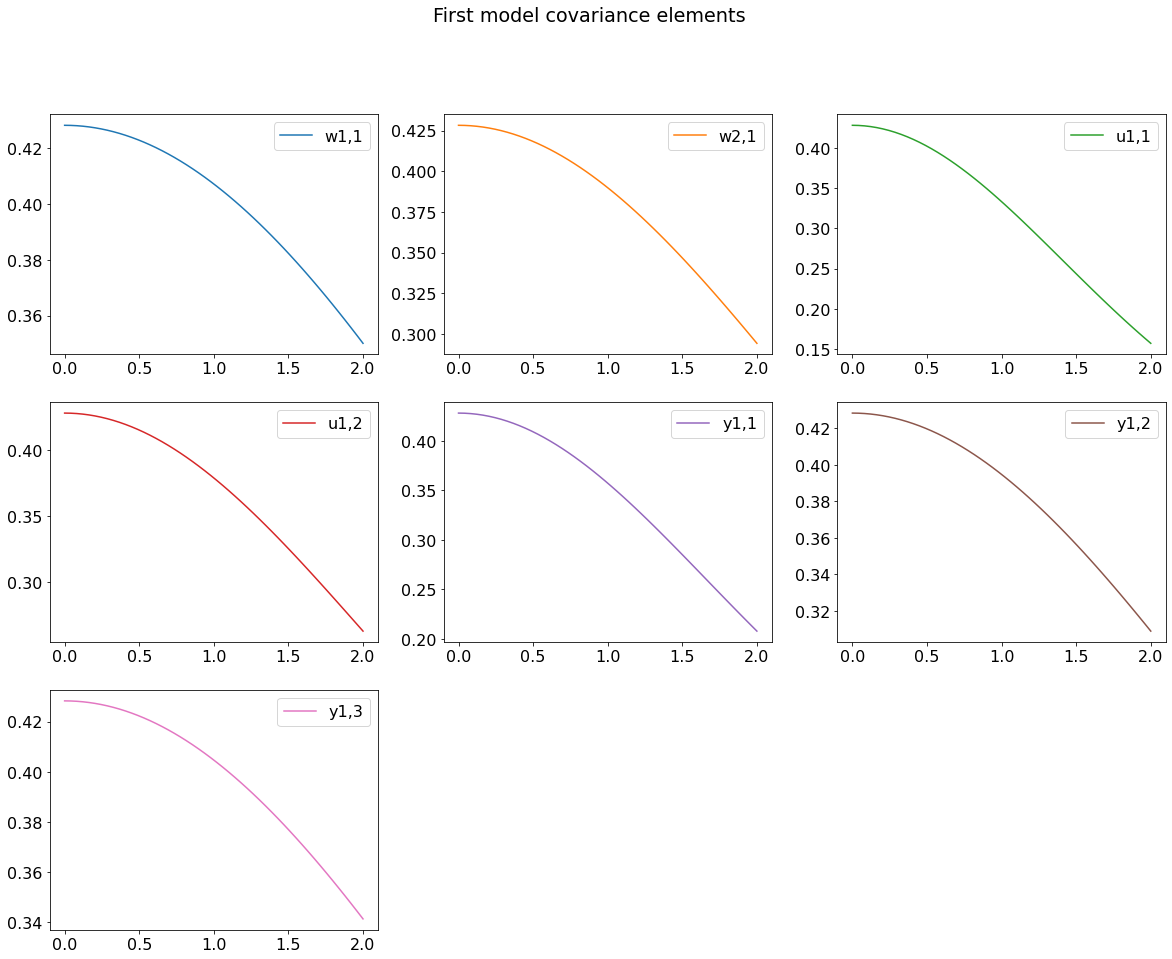

In [44]:
gs = gridspec.GridSpec(3, 3)
lscale_names = ['w1,1', 'w2,1', 'u1,1', 'u1,2', 'y1,1', 'y1,2', 'y1,3']
x = np.linspace(0,2)

lscale_idx = 2 * idx + idxx

fig = plt.figure(figsize = (20, 15))

var = np_params[0, 0]
for idxx in range(7):
    x_idx, y_idx = divmod(idxx, 3)
    ax = fig.add_subplot(gs[x_idx, y_idx])
    lscale_iter = np_params[0, 1 + idxx]
    y = var*np.exp(-1/2*x**2/lscale_iter)
    ax.plot(x, y, color = pallete[idxx], label = lscale_names[idxx])
    ax.legend()
fig.suptitle("First model covariance elements")
plt.savefig(f"../Thesis/Plots/{sim_id}_first_covariance.pdf", bbox_inches='tight')

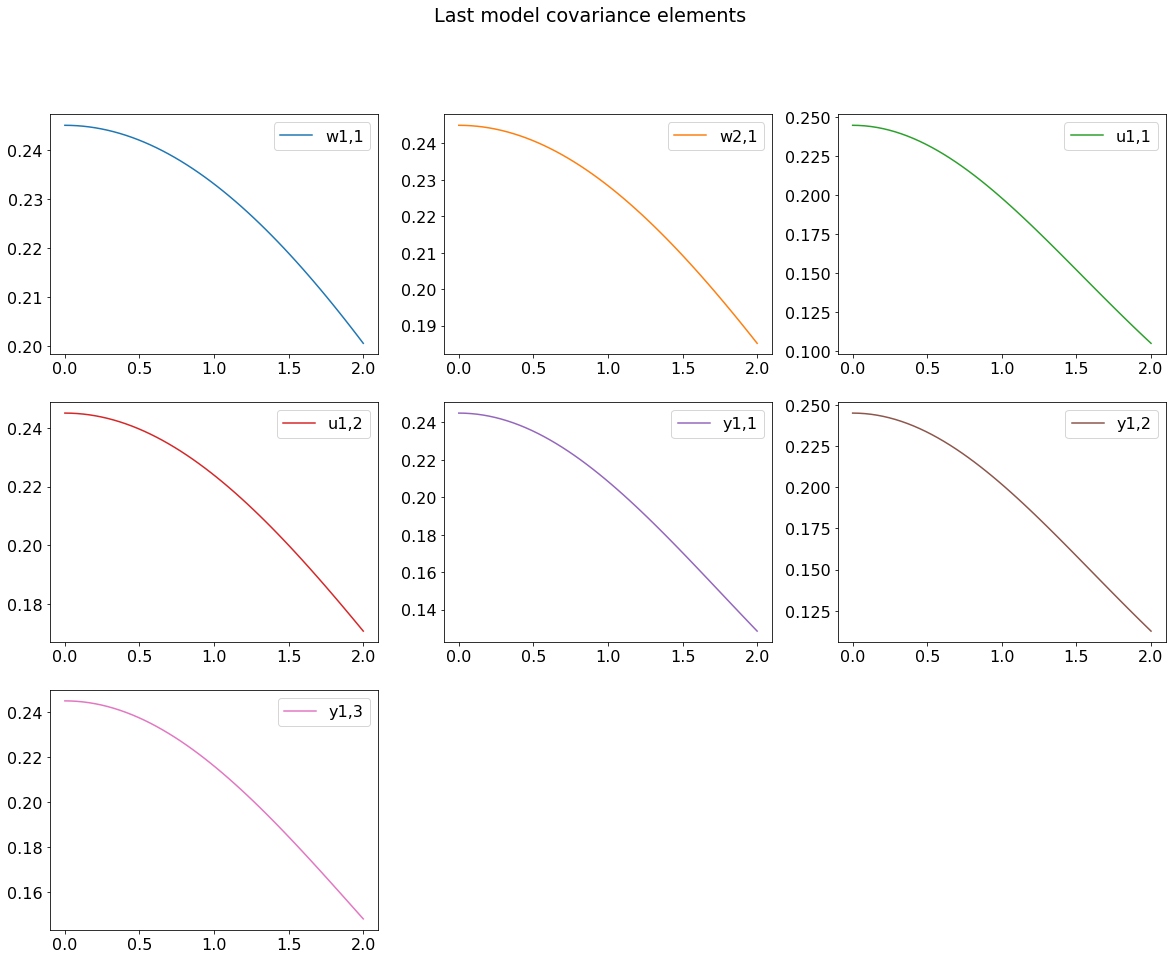

In [43]:
gs = gridspec.GridSpec(3, 3)
lscale_names = ['w1,1', 'w2,1', 'u1,1', 'u1,2', 'y1,1', 'y1,2', 'y1,3']
x = np.linspace(0,2)

lscale_idx = 2 * idx + idxx

fig = plt.figure(figsize = (20, 15))

var = np_params[-1, 0]
for idxx in range(7):
    x_idx, y_idx = divmod(idxx, 3)
    ax = fig.add_subplot(gs[x_idx, y_idx])
    lscale_iter = np_params[-1, 1 + idxx]
    y = var*np.exp(-1/2*x**2/lscale_iter)
    ax.plot(x, y, color = pallete[idxx], label = lscale_names[idxx])
    ax.legend()
fig.suptitle("Last model covariance elements")
plt.savefig(f"../Thesis/Plots/{sim_id}_last_covariance.pdf", bbox_inches='tight')